In [18]:
# !pip install seaborn absl-py scikit-image tensorboard huggingface-hub datasets

In [19]:
# !pip install pyarrow

In [20]:
# !pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

In [1]:
# !pip install accelerate 
# !pip install bitsandbytes
# !pip uninstall huggingface_hub -y
# !pip install huggingface_hub
# !pip install sacrebleu

In [1]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad", split="train")
test_dataset = load_dataset("flaviagiammarino/vqa-rad", split="test")

In [2]:
# dataset[0]['image']

In [3]:
# dataset[0]["question"]

In [4]:
# dataset[0]["answer"]

In [5]:
als = []
for d in dataset:
    als.append(len(d['answer'].split(' ')))
    # break

In [7]:
from collections import Counter

Counter(als)

Counter({1: 1321,
         2: 229,
         3: 104,
         4: 54,
         5: 28,
         6: 15,
         7: 15,
         8: 12,
         9: 6,
         14: 4,
         13: 3,
         17: 1,
         10: 1})

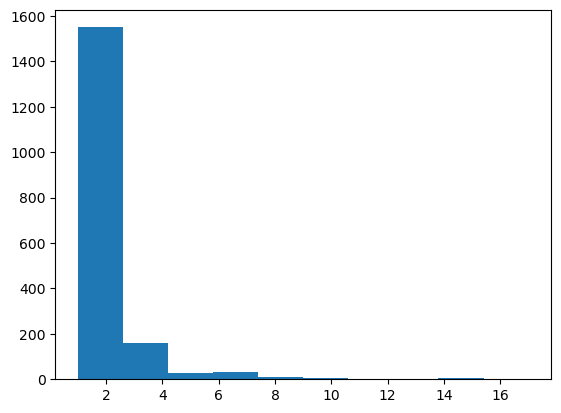

In [8]:
import matplotlib.pyplot as plt

_ = plt.hist(als)

In [6]:
# !pip install peft

In [2]:
import torch
torch.cuda.empty_cache()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

2

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, dataset, processor, image_size=224, convert_mode='RGB', qtype='CLOSED'):
        self.dataset = dataset
        self.processor = processor
        # self.transform = transforms.Compose([
        #     transforms.Resize(image_size),  # Resize to a fixed size
        #     transforms.ToTensor(),  # Convert to tensor
        #     transforms.ConvertImageDtype(torch.float),  # Ensure float dtype for images
        #     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (example for RGB)
        # ])
        # if convert_mode.upper() == 'RGB':
        #     self.convert = transforms.Lambda(lambda img: img.convert('RGB'))
        # elif convert_mode.upper() == 'GRAYSCALE':
        #     self.convert = transforms.Lambda(lambda img: img.convert('L'))
        # else:
        #     raise ValueError("convert_mode must be 'RGB' or 'GRAYSCALE'")
        # self.indices = []
        # for i, d in enumerate(dataset):
        #     if 'CLOSED' == qtype and d['answer'] in ['yes', 'no']:
        #         self.indices.append(i)
        #     elif 'OPEN' == qtype:
        #         self.indices.append(i)

    def __len__(self):
        # return len(self.indices)
        return len(self.dataset)

    def __getitem__(self, idxi):
        # idx = self.indices[idxi]
        idx = idxi
        # get image + text
        question = self.dataset[idx]['question']
        answer = self.dataset[idx]['answer']
        image = self.dataset[idx]['image']
        # image = self.transform(image)
        template = "Question: {} Answer:"
        prompt = template.format(question)
        # print("text", text)
        encoding = self.processor(image, text=prompt, padding="max_length", truncation=True, return_tensors="pt")#.to(device="cuda:0")

        # encoding = self.processor(
        # image, prompt=text, padding="max_length", truncation=True, return_tensors="pt"
        # ).to(device="cuda", dtype=torch.bfloat16)

        # print("encoding",encoding.keys())

        labels = self.processor.tokenizer.encode(
            answer, max_length= 8, pad_to_max_length=True, return_tensors='pt'
        )
        encoding["labels"] = labels

        # remove batch dimension
        for k,v in encoding.items():  encoding[k] = v.squeeze()
        encoding["answer"] = answer
        return encoding


from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    processed_batch = {}
    
    input_ids_list = []
    attention_mask_list = []
    pixel_values_list = []
    labels_list = []

    for item in batch:
        input_ids_list.append(item['input_ids'])
        attention_mask_list.append(item['attention_mask'])
        pixel_values_list.append(item['pixel_values'])  # Assuming pixel_values need no padding
        labels_list.append(item['labels'])

    processed_batch['input_ids'] = pad_sequence(input_ids_list, batch_first=True, padding_value=0)  # Check the appropriate padding_value for your tokenizer
    processed_batch['attention_mask'] = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)
    processed_batch['labels'] = pad_sequence(labels_list, batch_first=True, padding_value=0)

    processed_batch['pixel_values'] = torch.stack(pixel_values_list)#.to(device)

    return processed_batch

In [7]:
import os
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from accelerate import accelerator

os.environ['HF_HOME'] = '/data/vep52/nlp/huggingface/hub'

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# processor.tokenizer.padding_side='left'
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    # device_map="auto",
    cache_dir = os.environ['HF_HOME']
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
model.to(device)
model.device

device(type='cuda', index=1)

In [7]:
train_dataset = VQADataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=48, collate_fn=collate_fn)
test_dataset2 = VQADataset(test_dataset, processor)
valid_dataloader = DataLoader(test_dataset2, shuffle=False, batch_size=48, collate_fn=collate_fn)

In [8]:
len(train_dataset)

1793

In [11]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head",],
)

model = get_peft_model(model, config)
model.print_trainable_parameters()


model.to(device)

# torch.cuda.empty_cache()
torch.manual_seed(42)

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [12]:
from tqdm import tqdm
import torch
import pickle

def compute_accuracy(predictions, labels):
    # Assuming predictions are logits for classification
    preds = torch.argmax(predictions, dim=1)  # Convert logits to class predictions
    correct_count = (preds == labels).sum().item()  # Count correct predictions
    total_count = labels.size(0)  # Total number of labels
    accuracy = correct_count / total_count  # Calculate accuracy
    return accuracy


optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

num_epochs = 30
patience = 5
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)), desc='Training batch: ...'), train_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float32):
            # print("input_ids",input_ids.dtype)
            # print("pixel_values", pixel_values.dtype)
            # print("labels", labels.dtype)
            outputs = model(input_ids=input_ids.to(device),
                        pixel_values=pixel_values.to(device, dtype=torch.float32),
                        attention_mask=attention_masked,
                        labels=labels.to(device))

        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()



    model.eval()
    eval_loss = 0
    total_accuracy = 0

    for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc='Validating batch: ...'), valid_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float32):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)

        loss = outputs.loss
        eval_loss += loss.item()


        # Inside your validation loop, after obtaining `outputs`:
        # accuracy = compute_accuracy(outputs.logits, labels)  # Calculate accuracy for the current batch
        # total_accuracy += accuracy  # Accumulate accuracy

    # After the loop, calculate average accuracy over all batches
    # validation_accuracy = total_accuracy / len(valid_dataloader)
    # print(f"Validation Accuracy: {validation_accuracy}")


    tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    scheduler.step()
    if eval_loss < min_eval_loss:
        model.save_pretrained("Model/blip-saved-model", from_pt=True)
        pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
        print("Saved model to Model/blip-saved-model")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break


print("The finetuning process is complete!")


Training batch: ...:   0%|                                                                                                                            | 0/38 [00:00<?, ?it/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/data/vep52/miniforge3/envs/med_vqa/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

Epoch: 1 - Training loss: 12.6740174544485 - Eval Loss: 10.4786771774292 - LR: 4e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


Epoch: 2 - Training loss: 8.007437718541999 - Eval Loss: 6.026336812973023 - LR: 3.6e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


Epoch: 3 - Training loss: 5.869259796644512 - Eval Loss: 5.178172874450683 - LR: 3.24e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]


Epoch: 4 - Training loss: 5.183481931686401 - Eval Loss: 4.42564582824707 - LR: 2.9160000000000002e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]


Epoch: 5 - Training loss: 4.549596585725483 - Eval Loss: 3.9131113052368165 - LR: 2.6244e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.74s/it]


Epoch: 6 - Training loss: 4.112212337945637 - Eval Loss: 3.5659050703048707 - LR: 2.3619600000000003e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.81s/it]


Epoch: 7 - Training loss: 3.8308552503585815 - Eval Loss: 3.3193510293960573 - LR: 2.1257640000000004e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.78s/it]


Epoch: 8 - Training loss: 3.6567132472991943 - Eval Loss: 3.209427332878113 - LR: 1.9131876000000003e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]


Epoch: 9 - Training loss: 3.5204242593363713 - Eval Loss: 3.0753605127334596 - LR: 1.7218688400000002e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.72s/it]


Epoch: 10 - Training loss: 3.3859461294977287 - Eval Loss: 2.997171902656555 - LR: 1.5496819560000003e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.55s/it]


Epoch: 11 - Training loss: 3.312518308037206 - Eval Loss: 2.9366922616958617 - LR: 1.3947137604000003e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]


Epoch: 12 - Training loss: 3.2630503805060136 - Eval Loss: 2.870720314979553 - LR: 1.2552423843600002e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


Epoch: 13 - Training loss: 3.227937597977488 - Eval Loss: 2.8480037450790405 - LR: 1.1297181459240002e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


Epoch: 14 - Training loss: 3.134063206220928 - Eval Loss: 2.811699891090393 - LR: 1.0167463313316002e-05
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.50s/it]


Epoch: 15 - Training loss: 3.099856646437394 - Eval Loss: 2.7822338581085204 - LR: 9.150716981984402e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]


Epoch: 16 - Training loss: 3.07992736916793 - Eval Loss: 2.7561601877212523 - LR: 8.235645283785962e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


Epoch: 17 - Training loss: 3.0588000761835197 - Eval Loss: 2.730756092071533 - LR: 7.412080755407366e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.86s/it]


Epoch: 18 - Training loss: 3.0125469032086825 - Eval Loss: 2.714875078201294 - LR: 6.6708726798666295e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.75s/it]


Epoch: 19 - Training loss: 3.008017847412511 - Eval Loss: 2.7022029876708986 - LR: 6.003785411879967e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.03s/it]


Epoch: 20 - Training loss: 2.9740535177682577 - Eval Loss: 2.6836514234542848 - LR: 5.40340687069197e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.74s/it]


Epoch: 21 - Training loss: 2.983707823251423 - Eval Loss: 2.6847532629966735 - LR: 4.863066183622773e-06


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.86s/it]


Epoch: 22 - Training loss: 2.9856331787611308 - Eval Loss: 2.669867658615112 - LR: 4.3767595652604964e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]


Epoch: 23 - Training loss: 2.9564473252547416 - Eval Loss: 2.6566402554512023 - LR: 3.939083608734447e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.62s/it]


Epoch: 24 - Training loss: 2.9520804756566097 - Eval Loss: 2.6461278319358827 - LR: 3.5451752478610023e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.57s/it]


Epoch: 25 - Training loss: 2.9540175952409444 - Eval Loss: 2.6539746284484864 - LR: 3.190657723074902e-06


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.85s/it]


Epoch: 26 - Training loss: 2.9752013244126974 - Eval Loss: 2.6389620661735536 - LR: 2.871591950767412e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.60s/it]


Epoch: 27 - Training loss: 2.930314584782249 - Eval Loss: 2.637747609615326 - LR: 2.5844327556906708e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


Epoch: 28 - Training loss: 2.9385471218510677 - Eval Loss: 2.6316360354423525 - LR: 2.3259894801216037e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.51s/it]


Epoch: 29 - Training loss: 2.922991482835067 - Eval Loss: 2.625326669216156 - LR: 2.0933905321094435e-06
Saved model to Model/blip-saved-model


Validating batch: ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.55s/it]

Epoch: 30 - Training loss: 2.9147607276314185 - Eval Loss: 2.6214463829994203 - LR: 1.8840514788984991e-06
Saved model to Model/blip-saved-model
The finetuning process is complete!


In [13]:
!ls Model/blip-saved-model/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


README.md  adapter_config.json	adapter_model.safetensors


In [9]:
import pickle
with open("tracking_information.pkl", "rb") as rf:
    tracking_information = pickle.load(rf)

In [14]:
len(test_dataset)

451

In [16]:
model.eval()
from tqdm import tqdm
answers = []
predicted_answers = []

torch.manual_seed(0)
for batch in tqdm(test_dataset):
    inputs = processor(images=batch['image'], text=batch['question'], return_tensors="pt").to(
        device=device
    )
    
    generated_ids = model.generate(**inputs,
                                   max_length=100,
                                   temperature=0.0,
                                   num_beams=2,
                                   early_stopping=True,
                                   min_length=1,
                                   repetition_penalty=1.81,
                                   )
    generated_answers = processor.batch_decode(generated_ids, skip_special_tokens=True)

    predicted_answers.extend(generated_answers)
    answers.append(batch['answer'])

  0%|                                                                                                                                                | 0/451 [00:00<?, ?it/s]/data/vep52/miniforge3/envs/med_vqa/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 451/451 [22:28<00:00,  2.99s/it]


In [17]:
len(answers), len(predicted_answers)

(451, 451)

In [18]:
from difflib import SequenceMatcher

hypotheses = []
references = []

ratios = []

# correct 
tp = 0
tn = 0
fp = 0
fn = 0

for a, pa in zip(answers, predicted_answers):
    if a in ['yes','no']:
        if pa.startswith(a):
            if a == 'yes':
                tp += 1
            elif pa == 'no' or pa.startswith('no ') or pa.startswith('non'):
                tn += 1
        else:
            if a == 'yes':
                fn += 1
            else:
                fp += 1
    else:
        # hypotheses.append(pa)
        # references.append(a)
        ratios.append(SequenceMatcher(a=a, b=pa).ratio())

accuracy = (tp+tn)/(len(answers)-len(ratios))
ratio = sum(ratios)/len(ratios)
f"exact_match: {accuracy}", f"similarity: {ratio}", tp, tn, fp, fn

('exact_match: 0.398406374501992',
 'similarity: 0.026727220927717333',
 41,
 59,
 35,
 77)

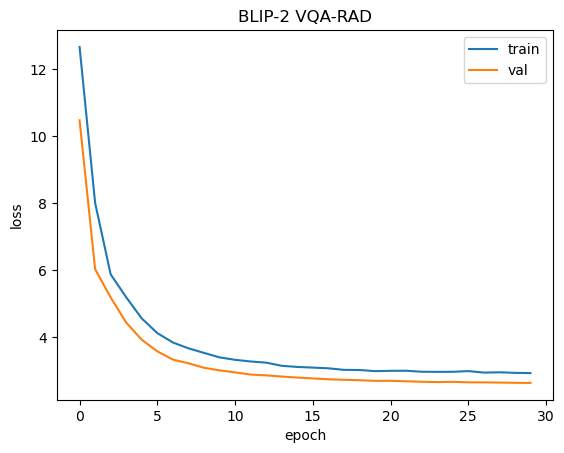

In [19]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.array(tracking_information)

plt.figure(1)
plt.clf()
plt.plot(arr[:,0], label='train')
plt.plot(arr[:,1], label='val')
plt.title('BLIP-2 VQA-RAD')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
_=plt.show()

In [20]:
import json
with open(f"Model/blip-saved-model/answers.json", "w") as wf:
    json.dump(answers, wf)
with open(f"Model/blip-saved-model/predicted_answers.json", "w") as wf:
    json.dump(predicted_answers, wf)   

In [4]:
import os
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from accelerate import accelerator
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel

peft_model_id = "Model/blip-saved-model"
config = PeftConfig.from_pretrained(peft_model_id)

print(config.base_model_name_or_path)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# processor.tokenizer.padding_side='left'

Salesforce/blip2-opt-2.7b


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model.to(device)
model.device

device(type='cuda', index=1)

In [6]:
model.device

device(type='cuda', index=1)

In [ ]:
def find_repeating_unit(s):
    # Find the first repeating unit in the string
    for i in range(1, len(s)):
        if s.startswith(s[i:]):
            return s[:i]
    return s.split(' ')[0]  # Return the whole string if no repetition is found

# Example list of strings
strings = hypotheses

# Extract the first repeating unit from each string
extracted_units = [find_repeating_unit(s) for s in strings]

# print(extracted_units)


extracted_units_2 = []
for f in extracted_units:
    if f.startswith('yes'):
        extracted_units_2.append('yes')
    elif f.startswith('no'):
        extracted_units_2.append('no')
    else:
        extracted_units_2.append(f)

# extracted_units_2



In [ ]:
import difflib

def calculate_similarity_score(s1, s2):
    """Calculate the similarity score between two strings."""
    return difflib.SequenceMatcher(None, s1, s2).ratio()

def calculate_difflib_accuracy(predicted_texts, actual_texts, threshold=0.8):
    """Calculate accuracy based on difflib's similarity scores."""
    correct_count = 0

    for predicted, actual in zip(predicted_texts, actual_texts):
        score = calculate_similarity_score(predicted, actual)
        if score >= threshold:
            correct_count += 1

    accuracy = correct_count / len(actual_texts)
    return accuracy

# Example usage
predicted_texts = extracted_units_2
actual_texts =  test_dataset[:]['answer']


accuracy = calculate_difflib_accuracy(predicted_texts, actual_texts)
print(f"Fuzzy Partial Accuracy: {accuracy:.2%}")
